# Hands-on: **Reduced modeling and recovery from uncomplete measurements**

The objective of the practical session is to understand in practice how to create a reduced basis and use it for solving a state estimation inverse problem or a forward problem.

Our base model will be the diffusion equation:
$$-div(a(x) \nabla u(x)) = 1,\quad x \in [0, 1]^2,$$
with homogeneus Dirichlet boundary conditions. We take a piecewise constant diffusion coefficient
$$a_{|D_j} = y_j, \quad 1\leq j \leq 4,$$
on the subdomains
$$D_0 = [0, 0.5]^2, D_1 = [0.5, 1]\times[0, 0.5], D_2 = [0, 0.5]\times[0.5, 1], D_3 = [0.5, 1]^2.$$
Thus the solution $u$ depends on a parameter $y=(y_1,\dots,y_4)$ which we pick in the parameter space 
$$Y= [a_{min}, a_{max}]^4.$$

In the inverse problem case, our goal is to approximate a state $u(x|y)$ on the whole domain $x\in [0,1]^2$ for some unknown parameter $y$, based on a few point measurements $u(x^i|y)$ at chosen points $x^1,\dots,x^m\in [0,1]^2$. We procced in the following way:

Offline stage:

1) **Compute $N$ solutions** (snapshots) $u^1=u(\cdot,y^1), \dots, u^N=u(\cdot, y^N)$ from a chosen set of parameters $\{y^1, \dots ,y^N\}\in Y^N$.

2) Create a **reduced basis** $V_n$ of dimension $n\leq N$ using the $N$ precomputed snapshots to find the optimal subspace. Optimal in which sense?
- Pick randomly: This new space is generated by the solutions $V_n \subset span\{u^1,\dots,u^N \}$
- Greedy method (optimal with respect to $L_{\infty}$): This new space is generated by the solutions $V_n \subset span\{u^1,\dots,u^N \}$.
- PCA (optimal with respect to $L_{2}$).

Online stage:

3) **Measurements**: obtain $m$ observations $u(x^i,y)$ (+noise), $1\leq i \leq m$, of a solution $u(\cdot,y)$ whith unknown parameter $y$.

4) **State estimation**: construct an approximation $\tilde u\in V_n$ of $u(\cdot,y)$ based on these measurements.

5) **Error analysis**: compute the error $\|\tilde u- u(\cdot,y)\|_{L^2}$ and study its behaviour depending on the reduced basis and the measurements.


## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
project_path = os.path.abspath(os.path.join(src_path, os.pardir))
sys.path.insert(1, src_path)
sys.path.insert(1, project_path)

In [35]:
from typing import List, Tuple

import matplotlib.pylab as plt
import numpy as np

from src.lib.VizUtils import plot_solutions_together, plot_approximate_solutions_together, plot_solution
from src.lib.SolutionsManagers import SolutionsManagerFEM
from src.notebooks.functions4notebooks import *

import ipywidgets as widgets
from ipywidgets import GridspecLayout

np.random.seed(42)

In [4]:
# to center plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Parameters and definitions

In [5]:
diffusion_contrast_lower = 1 # a_min
diffusion_contrast_upper = 100 # a_max

#### Defining V space
We will generate the offline solutions with a Galerkin method, in the space $V$ of Finite Element Method:
- blocks_geometry: how many subdomains with varying diffusion coefficients, we set $(2, 2)$ but you can play with other rectangular geometries.
- N the number of points in the FEM discretization per dimension and per block: so if $N=10$ and the geometry is $(2, 2)$ then $(10*2-1)^2=361=dim(V)$ (the -1 accounts for the fact that points in the boundary do not add degrees of freedom).

In [6]:
# object that knows how to create the solutions to the PDE + projections etc
sm = SolutionsManagerFEM(blocks_geometry=(2,2), N=10, num_cores=1)
print("The space V has dimension {}".format(sm.vspace_dim))

The space V has dimension 361


#### Display parameters

In [7]:
num_points_per_dim_to_plot = 50 # size of the plotted images
axes_xy_proportions = (3, 3)

# Intuition about the problem

#### Play yourself to gain intuition!!!

Change the values of the parameters to see how the solution changes and gain some intuition.

In [8]:
visualize_intuition(sm, diffusion_contrast_lower, diffusion_contrast_upper,
                        num_points_per_dim_to_plot=50, axes_xy_proportions=(3, 3))

GridspecLayout(children=(FloatSlider(value=50.0, continuous_update=False, description='a[0,0]:', layout=Layout…

Output()

## **_Offline stage_**

In [9]:
number_of_solutions = 100 # N
number_of_reduced_base_elements = 20  # n < N
number_of_measures = 50  # m >= n

## 1) **Compute offline solutions**

#### Solution sampling method

To create our offline solutions we need to sample the solution manifold by giving $N$ values of the parameters $y$. This can be done in many ways:

1. Uniformly sampling $y \in Y= [a_{min}, a_{max}]^4$.
2. Making a grid of the four dimensional space $Y$.
3. Log-uniform sample $y \in Y$.
4. ...

The choice may impact the reduced space we will generate afterwards, and the solutions were we are going to test.


In [10]:
def solution_sampling_method_uniform(n, diffusion_contrast_lower, diffusion_contrast_upper, num_blocks):
    return np.random.uniform(diffusion_contrast_lower, diffusion_contrast_upper, size=(n, num_blocks))

def solution_sampling_method_grid(n, diffusion_contrast_lower, diffusion_contrast_upper, num_blocks):
    # creat the grid
    params = np.array(list(map(np.ravel, np.meshgrid(*[np.linspace(diffusion_contrast_lower, diffusion_contrast_upper, num=int(np.ceil(n**(1/num_blocks))))]*num_blocks)))).T
    # randomly choose n
    ix = np.random.choice(len(params), size=n, replace=False)
    return params[ix, :]

In [11]:
solution_sampling_method = solution_sampling_method_uniform

#### Compute solutions

In [12]:
diffusion_coefficients = solution_sampling_method(number_of_solutions, diffusion_contrast_lower, diffusion_contrast_upper, np.prod(sm.blocks_geometry))
diffusion_coefficients = diffusion_coefficients.reshape((-1,)+sm.blocks_geometry)
solutions = sm.generate_solutions(diffusion_coefficients)

#### Visualize solutions

#### Visualize solutions intuition

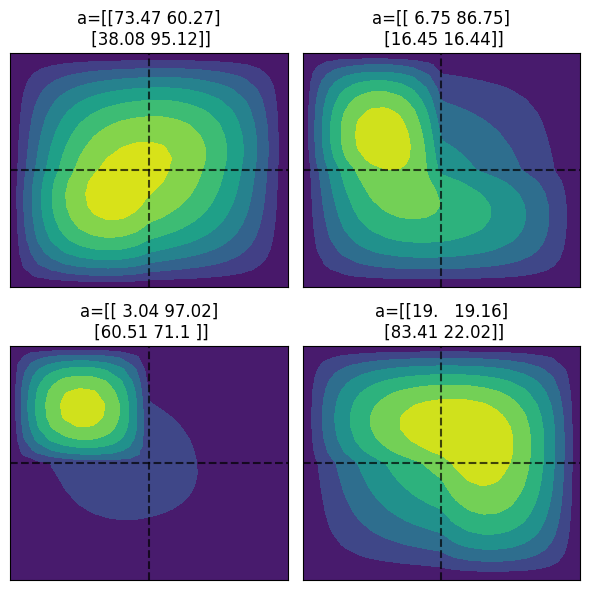

In [13]:
plot_solutions_together(
    sm,
    diffusion_coefficients=diffusion_coefficients[:4], 
    solutions=solutions[:4], 
    num_points_per_dim_to_plot=100,
    contour_levels=7,
    colorbar=False,
    axes_xy_proportions=axes_xy_proportions
)


## 2) **Generate Reduced Basis**

Now we are going to create the reduced basis $V_n = span\{v_1, \dots , v_n \}$. For that we will need the previously $N$ precomputed offline solutions and we will need also to code a method to effectively create this reduced basis subspace.


1. **Pick randomly**: a simple way is just to choose randomply $n$ elements from the $N$ snapshots.
2. **PCA (Principal Component Analysis)**: other method can be to do PCA with the $N$ solutions and choose the first eigenvectors to create our basis. Note that in this case the base elements will probably not be solutions to the PDE. This method tries to minimize the $L_{2}$ norm. (Hint: use scikit-learn)
3. **Greedy**: Use the greedy algorithm to incrementaly create a basis that minimizes the $L_\infty$ norm over the set of $N$ precomputed solutions. This method tries to minimize the $L_{\infty}$ norm.
4. For comparison, we can also use a basis of lower degree polynomials, without taking into account the physical model.
5. ...


In [14]:
def reduced_basis_generator(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int, 
                            *args, **kwargs) -> List[np.ndarray]:
    # does something
    return basis

In [15]:
#### Define reduced basis generator algorithm
"""
Scheme for a generic reduced_basis_generator method.
solutions_offline: List of solutions precalculated in an offline stage.

The output is a list of vectors forming the basis, they can be some chosen solutions (like in random or greedy methods) 
or just vectors than may not be in the solution manifold (like in PCA).
"""

def reduced_basis_generator_random(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int, seed=42) -> List[np.ndarray]:
    np.random.seed(seed)
    chosen_indexes = np.random.choice(len(solutions_offline), size=number_of_reduced_base_elements, replace=False)
    return [solutions_offline[ix] for ix in chosen_indexes]

def reduced_basis_generator_first_n(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int) -> List[np.ndarray]:
    # if the original offline solutions are random this will also be random.
    return solutions_offline[:number_of_reduced_base_elements]

from sklearn.decomposition import PCA

def reduced_basis_generator_pca(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int) -> List[np.ndarray]:
    # hint: look at PCA function from sklearn library.
    return PCA(n_components=number_of_reduced_base_elements).fit(solutions_offline).components_

def reduced_basis_generator_greedy(solutions_offline: List[np.ndarray], number_of_reduced_base_elements: int) -> List[np.ndarray]:
    # hint: add the vector (solution) with maximum distance to the actual space by calculating the differences between the solutions and the projections to the actual space.
    # for the projection solve the least square problem, you can use np.linalg.lstsq
    rb = [solutions_offline[np.argmax(np.mean((np.transpose(solutions_offline))**2, axis=0))]]
    for _ in range(1, number_of_reduced_base_elements):
        x = np.linalg.lstsq(np.transpose(rb), np.transpose(solutions_offline), rcond=None)[0]
        next_element = np.argmax(np.mean((np.transpose(solutions_offline) - np.transpose(rb) @ x)**2, axis=0))
        rb.append(solutions_offline[next_element])
    return rb

In [16]:
max_vn_dim = 20

reduced_basis_dict = {
    "PCA": reduced_basis_generator_pca(solutions, max_vn_dim),
    "Greedy": reduced_basis_generator_greedy(solutions, max_vn_dim), 
    "Random": reduced_basis_generator_random(solutions, max_vn_dim)
}

## **_Online stage_**

## 3) **Measurements**

Now we are ready to face a "real world" problem which consist on measuring (possibly with noise) our system at some points. Thess measurements can be specifically chosen points or just random observations. So we need to specify how thess $m$ observations are going to be obtained:
1. Sampling uniformly $m$ points in the domain.
2. Measures at points placed on a grid.
3. Sample only in one of the quadrants.
4. Adding more samples near the intersections of quadrants.
5. Sample randomly according to some other distribution.
6. ...

#### Define measurements sampling method

In [17]:
def measurements_sampling_method(number_of_measures: int, xlim: Tuple[float, float], ylim: Tuple[float, float]):
    # do something
    return sampled_points

In [24]:
def measurements_sampling_method_uniform(number_of_measures, xlim, ylim, seed=42):
    np.random.seed(seed)
    return np.hstack((np.random.uniform(*xlim, size=(number_of_measures, 1)), np.random.uniform(*ylim, size=(number_of_measures, 1))))

def measurements_sampling_method_grid(number_of_measures, xlim, ylim):
    n_per_dim = int(np.ceil(np.sqrt(number_of_measures)))
    x, y = np.meshgrid(*[np.linspace(*xlim, num=n_per_dim), np.linspace(*ylim, num=n_per_dim)])
    return np.concatenate([x.reshape((-1,1)), y.reshape((-1,1))], axis=1)

def measurements_sampling_method_optimal(number_of_measures, xlim, ylim):
    raise Exception("Not implemented")


In [25]:
measurements_sampling_method_dict = {
    "Random": measurements_sampling_method_uniform
}

## 4) **State Estimation**

With the measurements obtained in the test set and the reduced basis we can find which is the element in $V_n$ that better fits (in some norm, like $L_2$) the observations.

$$
\tilde u = \sum^n_{j=1} c_j v_j \quad \longrightarrow \quad \tilde u(x_i) = \sum^n_{j=1} c_j v_j(x_i)
$$

1. If, for example, we use the $L_2$ norm, 
$$
c = \underset{c}{arg\,min} ||u(x_i)-\tilde u(x_i)||_{L_2} = \underset{c}{arg\,min} \left( u(x_i)-\sum^n_{j=1} c_j v_j(x_i) \right)^2
$$
we end up having to solve a linear system $Ac=b$ where $b_i=u(x_i)$ are the measurement values, $A_{ij}=v_j(x_i)$ is a rectangular matrix $m\times n$ (whose $j$-th column corresponds to the evaluations of the $j$-th element of the reduced basis at points $x^1,\dots,x^n$), and $c$ is the coefficients of the element in $V_n$ that better fits the observations.
2. If we add different weights $w^i$ to the different evaluations (for instance, more weight near the intersections of the subdomains, where the solutions might degenerate if the contrast becomes high), we need to multiply $A$ and $b$ by a weight matrix $W=diag(w^1,\dots,w^m)$.
3. ...

In [20]:
def state_estimation_fitting_method(measurement_points, measurements, reduced_basis: List) -> (np.ndarray, np.ndarray):
    # do something
    return coefficients, approximate_solutions

In [27]:
def state_estimation_fitting_method_least_squares(measurement_points, measurements, reduced_basis: List):
    measurements_reduced_basis = sm.evaluate_solutions(measurement_points, reduced_basis)
    # solves the linear least squares problem Ax = b wehere b is the measurements; A is the rectangular matrix mxn whose columns
    # corresponds to the m evaluations of each element of the reduced basis in the measurement points.
    coefficients = np.linalg.lstsq(measurements_reduced_basis.T, measurements.T, rcond=-1)[0]
    approximate_solutions = coefficients.T @ np.array(reduced_basis)
    return coefficients, approximate_solutions

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV, MultiTaskLassoCV, LassoLarsIC

def polynomial_state_estimation_fitting_method_least_squares(measurement_points, measurements, reduced_basis: List, degree=2):
    measurements_reduced_basis = sm.evaluate_solutions(measurement_points, reduced_basis)
    model = Pipeline([('PF', PolynomialFeatures(degree=degree, include_bias=False)), ('LR', LinearRegression(fit_intercept=False))])
    # model = Pipeline([('PF', PolynomialFeatures(degree=degree, include_bias=False)), ('LR', MultiTaskLassoCV(fit_intercept=False))])
    # model = Pipeline([('PF', PolynomialFeatures(degree=degree, include_bias=False)), ('LR', LassoLarsIC(fit_intercept=False))])

    model.fit(measurements_reduced_basis.T, measurements.T)
    coefficients = model.steps[-1][1].coef_
    approximate_solutions = model.predict(np.array(reduced_basis).T).T
    return coefficients, approximate_solutions

def state_estimation_fitting_method_weighted_least_squares(measurement_points, measurements, reduced_basis: List):
    measurements_reduced_basis = sm.evaluate_solutions(measurement_points, reduced_basis)
    # solves the linear least squares problem Ax = b wehere b is the measurements; A is the rectangular matrix mxn whose columns
    # corresponds to the m evaluations of each element of the reduced basis in the measurement points.
    weights = np.sqrt(np.sum(measurements_reduced_basis**2, axis=0))

    coefficients = np.linalg.lstsq(measurements_reduced_basis.T * weights[:, np.newaxis], measurements.T * weights[:, np.newaxis], rcond=-1)[0]
    approximate_solutions = coefficients.T @ np.array(reduced_basis)
    return coefficients, approximate_solutions

    raise Exception("Not implemented.")

state_estimation_method_dict = {
    "polynomial-least-squares": polynomial_state_estimation_fitting_method_least_squares,
    "least-squares": state_estimation_fitting_method_least_squares,
    "weighted-least-squares": state_estimation_fitting_method_weighted_least_squares
}

#### Visualize approximations

In [28]:
vizualize_approximations(sm, measurements_sampling_method_dict, reduced_basis_dict, state_estimation_method_dict,
                             diffusion_contrast_lower, diffusion_contrast_upper, max_vn_dim,
                             num_points_per_dim_to_plot=50, axes_xy_proportions=(3, 3))

GridspecLayout(children=(GridspecLayout(children=(FloatSlider(value=50.0, continuous_update=False, description…

Output()

## 5) **Reduced basis error**

Now that we have all the steps of the state estimation pipeline we can ask ourselves how behaves empirically the approximation error of the state estimation problem when we:
1. Increase the number of basis elements $n$.
2. Change the number of measurements $m$.
3. Add noise to the measurements (by specifying the $\sigma$ of a normally distributed noise $N(0, \sigma)$).
4. Change the reduced basis.
5. Change the measurements sampling method.
6. ...

In [23]:
visualize_convergence(sm, solutions, measurements_sampling_method_dict, reduced_basis_dict,
                          state_estimation_method_dict, max_vn_dim)

GridspecLayout(children=(Dropdown(description='Error metric: ', layout=Layout(grid_area='widget001'), options=…

Output()

In [37]:

from src.notebooks.functions4notebooks import *
visualize_state_estimation_methods(sm, solutions, measurements_sampling_method_dict, reduced_basis_dict,
                                       state_estimation_method_dict, max_vn_dim)

GridspecLayout(children=(Dropdown(description='Error metric: ', layout=Layout(grid_area='widget001'), options=…

Output()